In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np


dataset = load_dataset('ag_news')

def simple_tokenizer(text):
    return text.lower().replace("'", "").split()

from collections import Counter
counter = Counter()
for ex in dataset['train']:
    counter.update(simple_tokenizer(ex['text']))

vocab_size = 20000
most_common = [t for t,_ in counter.most_common(vocab_size - 2)]
vocab = {t:i+2 for i,t in enumerate(most_common)}
vocab['<pad>'] = 0; vocab['<unk>'] = 1

def encode(text):
    return [vocab.get(w,1) for w in simple_tokenizer(text)]

class NewsDataset(Dataset):
    def __init__(self, split): self.data = dataset[split]
    def __len__(self): return len(self.data)
    def __getitem__(self, i):
        txt = torch.tensor(encode(self.data[i]['text']),dtype=torch.long)
        lbl = self.data[i]['label']
        return txt, lbl

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    xs, ys = zip(*batch)
    lengths = [x.size(0) for x in xs]
    xs = pad_sequence(xs, batch_first=True, padding_value=0)
    return xs, torch.tensor(ys), lengths

loader = DataLoader(NewsDataset('train'), batch_size=64, shuffle=True, collate_fn=collate_fn)


train_size = int(0.9 * len(loader.dataset))
val_size = len(loader.dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(loader.dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=64, collate_fn=collate_fn)

c:\Users\pnkdl\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-8) -> None:
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):        
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

class MambaBlock(nn.Module):
    def __init__(self, d_input, d_model):
        super(MambaBlock, self).__init__()
        self.in_proj = nn.Linear(d_input, d_model)
        self.s_B = nn.Linear(d_model, d_model)
        self.s_C = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_input)
        self.norm = RMSNorm(d_model)

    def forward(self, x):
        x = self.in_proj(x)
        B, C = self.s_B(x), self.s_C(x)
        x = x + B + C
        x = self.norm(x)  # Нормализация
        return self.out_proj(x)

class Mamba(nn.Module):
    def __init__(self, num_layers, d_input, d_model):
        super(Mamba, self).__init__()
        self.layers = nn.ModuleList([MambaBlock(d_input, d_model) for _ in range(num_layers)])

    def forward(self, seq):
        hidden_states = []
        for mamba in self.layers:
            seq = mamba(seq)
            hidden_states.append(seq.detach().cpu())
        return seq, hidden_states
    
    
class MambaModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_layers=3, hidden_dim=256, num_classes=4, max_len=500):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, embed_dim))
        self.mamba = Mamba(num_layers=num_layers, d_input=embed_dim, d_model=hidden_dim)

        self.fc_out = nn.Linear(embed_dim, num_classes)
        self.hidden_states = []

    def forward(self, x):
        B, S = x.size()
        emb = self.embedding(x) + self.positional_encoding[:, :S, :]
        out, self.hidden_states = self.mamba(emb)
        pooled = out.mean(dim=1)
        logits = self.fc_out(pooled)
        return logits

# Обучение
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MambaModel(len(vocab), num_layers=3, hidden_dim=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

losses, accuracies = [], []

def evaluate(model, loader):
    model.eval(); correct=0; total=0
    with torch.no_grad():
        for x,y,_ in loader:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct/total

epochs = 5
for ep in range(epochs):
    model.train(); total_loss=0
    for x,y,_ in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    val_acc = evaluate(model, val_loader)
    losses.append(avg_loss)
    accuracies.append(val_acc)
    print(f"Epoch {ep+1}/{epochs}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/5, Loss: 0.7532, Val Acc: 0.8024
Epoch 2/5, Loss: 0.4649, Val Acc: 0.8471
Epoch 3/5, Loss: 0.3957, Val Acc: 0.8661
Epoch 4/5, Loss: 0.3552, Val Acc: 0.8735
Epoch 5/5, Loss: 0.3245, Val Acc: 0.8838


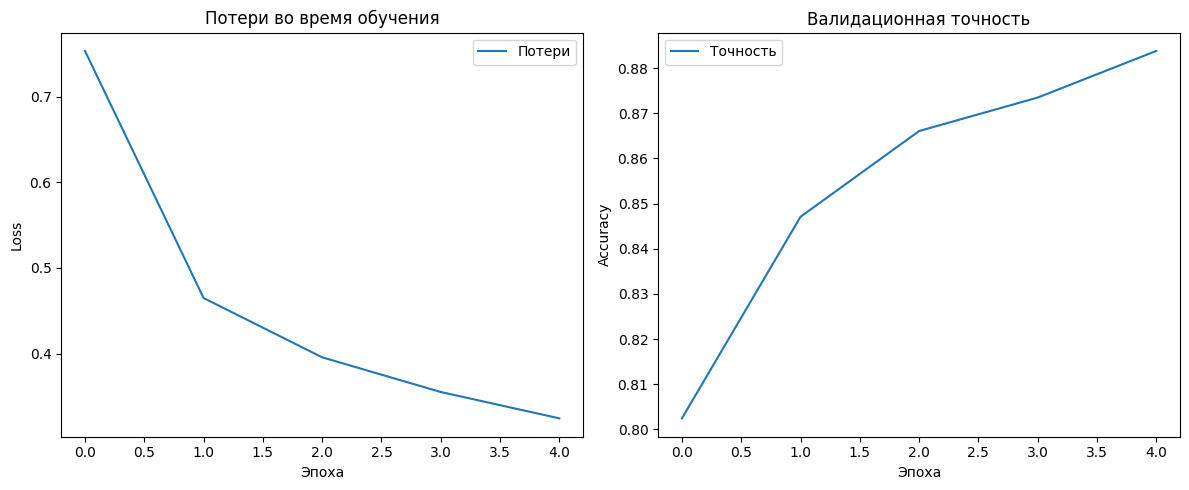

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses, label='Потери')
plt.title('Потери во время обучения')
plt.xlabel('Эпоха'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracies, label='Точность')
plt.title('Валидационная точность')
plt.xlabel('Эпоха'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

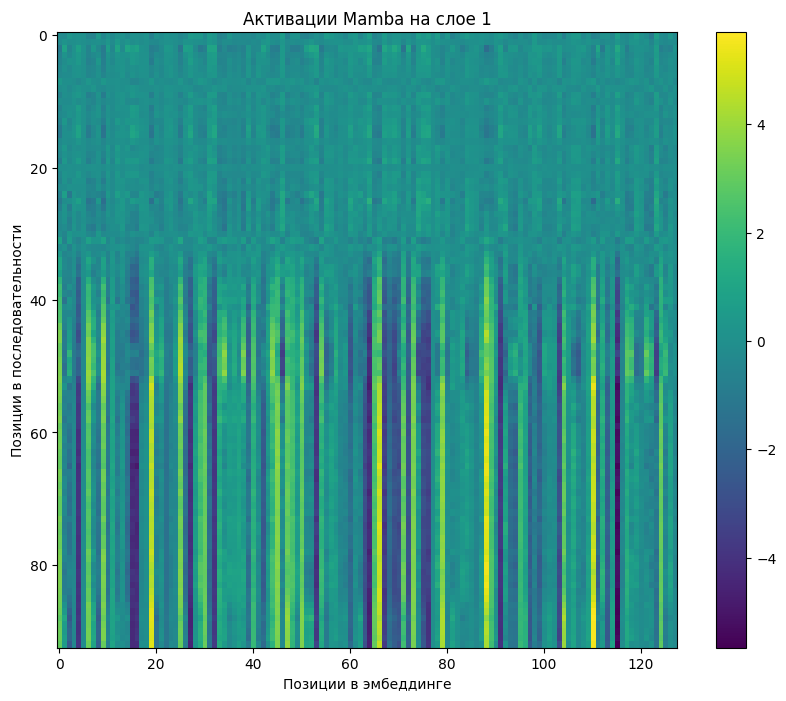

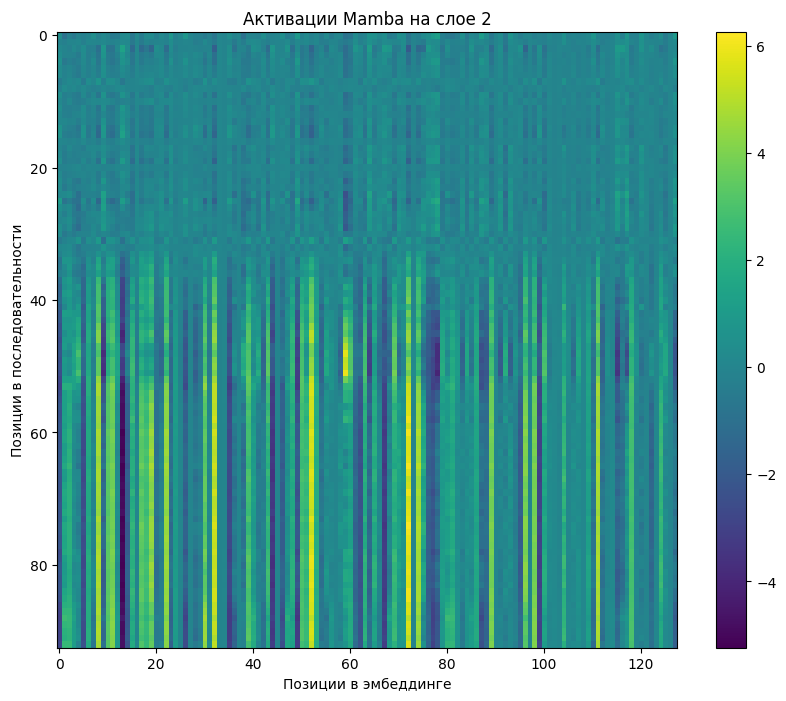

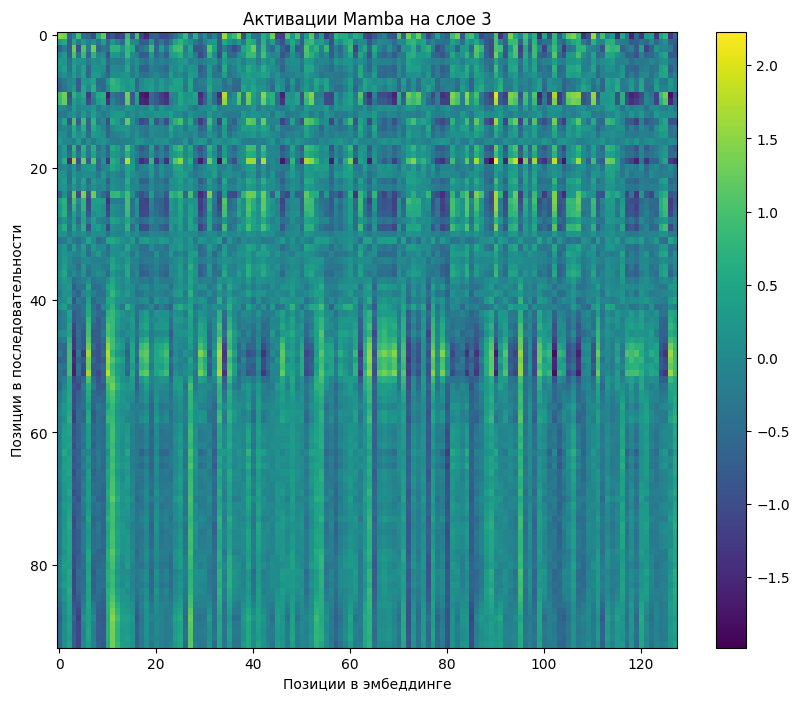

In [47]:
x, y, _ = next(iter(val_loader))
x = x.to(device)
_ = model(x)  # Заполняем model.hidden_states

for layer_idx, h in enumerate(model.hidden_states):
    activation = h.mean(dim=0).squeeze().numpy()
    plt.figure(figsize=(10, 8))
    plt.imshow(activation, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(f"Активации Mamba на слое {layer_idx + 1}")
    plt.xlabel("Позиции в эмбеддинге")
    plt.ylabel("Позиции в последовательности")
    plt.show()

## Выводы

Модель довольно хрошо обучилась на решение задачи (acc = 0.88)

По весам внимания видим, что на ранних слоях модель уделяет сильное внимание конкретным элементам эмбединга, более того в конце последовательности внимание более сильно дифференцировано(есть и больие веса и маленькие), в то время как в начале последовательности все веса около 0, а последний слой обращает внимание юольше на начало и середину последовательности. Это все лучше видно если смотреть на абсолютные значения

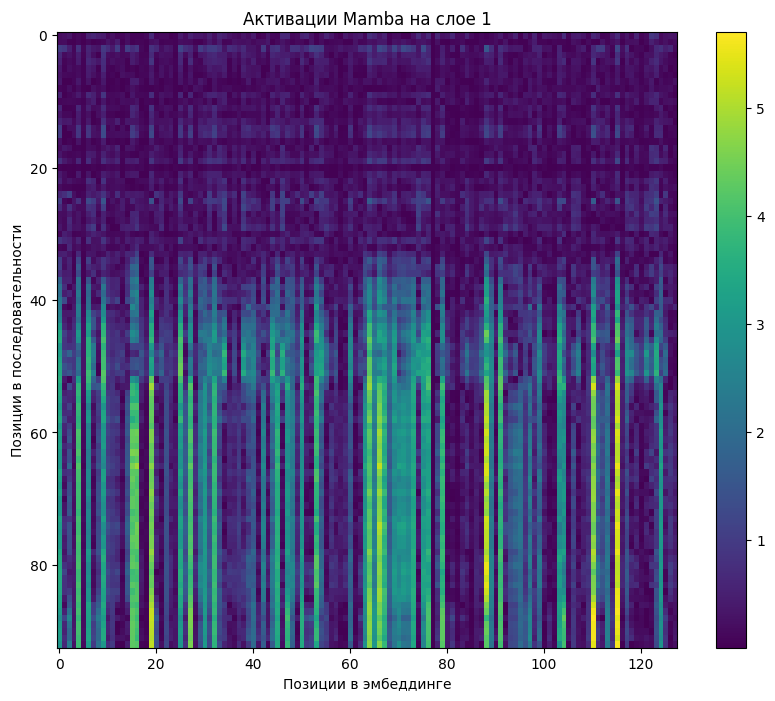

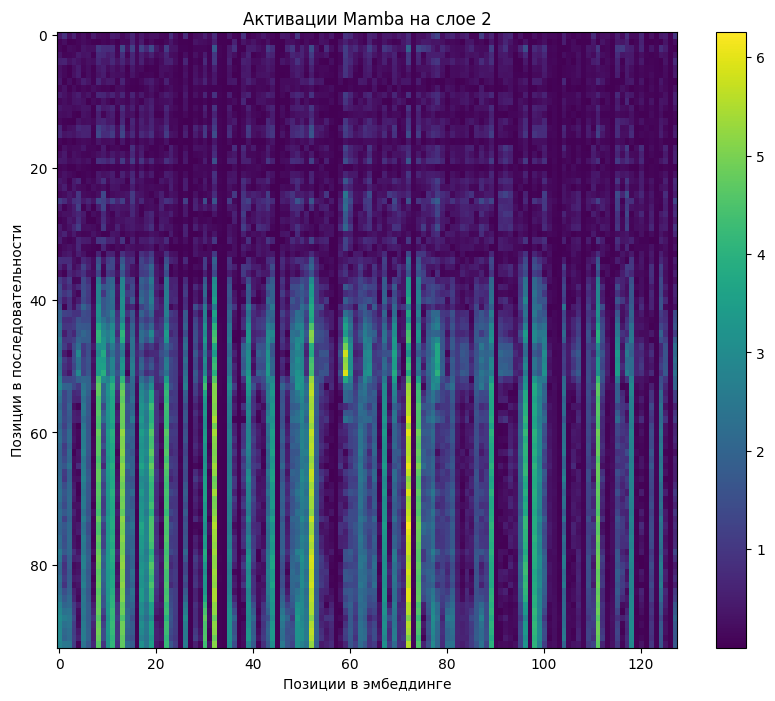

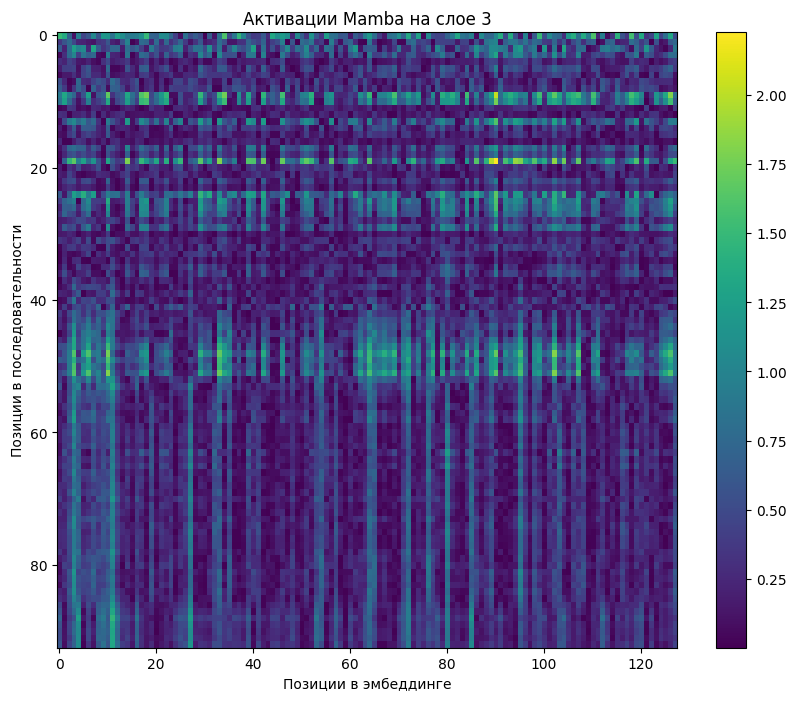

In [48]:
x, y, _ = next(iter(val_loader))
x = x.to(device)
_ = model(x)  # Заполняем model.hidden_states

for layer_idx, h in enumerate(model.hidden_states):
    activation = h.mean(dim=0).abs().squeeze().numpy()
    plt.figure(figsize=(10, 8))
    plt.imshow(activation, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(f"Активации Mamba на слое {layer_idx + 1}")
    plt.xlabel("Позиции в эмбеддинге")
    plt.ylabel("Позиции в последовательности")
    plt.show()